In [151]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
import  matplotlib.pyplot as plt
import torch
from torch import  nn,optim

In [152]:
train= pd.read_excel('../dataset/pre_train.xlsx')
test= pd.read_excel('../dataset/pre_test.xlsx')

In [153]:
X_columns = [col for col in train.columns if col not in ['time']]
Y_columns =['AQ']

In [154]:
x_train=train[X_columns]
y_train=train[Y_columns]
x_test=test[X_columns]
y_test=test[Y_columns]

In [155]:
# device=torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("*********************")
print(torch.cuda.get_device_name(0))
print(device)

*********************
NVIDIA GeForce RTX 3070 Laptop GPU
cuda:0


In [156]:
from sklearn.preprocessing import MinMaxScaler
scaler1=MinMaxScaler(feature_range=(0.00000001,1))
scaler2=MinMaxScaler(feature_range=(0.00000001,1))
scaler3=MinMaxScaler(feature_range=(0.00000001,1))
scaler4=MinMaxScaler(feature_range=(0.00000001,1))
train_sca=pd.DataFrame()
test_sca=pd.DataFrame()
train_sca[X_columns]=scaler1.fit_transform(train[X_columns])
train_sca[Y_columns]=scaler2.fit_transform(train[Y_columns])
test_sca[X_columns]=scaler3.fit_transform(test[X_columns])
test_sca[Y_columns]=scaler4.fit_transform(test[Y_columns])
print(test_sca.shape)


(480, 17)


In [157]:
x_train_ts = torch.from_numpy(np.float32(train_sca[X_columns])).to(device)
y_train_ts = torch.from_numpy(np.float32(train_sca[Y_columns])).to(device)
x_test_ts = torch.from_numpy(np.float32(test_sca[X_columns])).to(device)
y_test_ts = torch.from_numpy(np.float32(test_sca[Y_columns])).to(device)

In [158]:
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
		#定义层
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.sig1 = nn.Tanh() #nn.Linear为线性关系，加上激活函数转为非线性
        self.drop1=nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.sig2 = nn.Sigmoid()
        self.drop2=nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        out = self.fc1(x)
        out = self.sig1(out)
        out = self.drop1(out)
        out = self.fc2(out)
        out = self.sig2(out)
        out = self.drop2(out)
        out = self.fc3(out)
        return out




In [159]:
input_dim = len(X_columns)   #一维向量长度
hidden_dim = 16            #hidden layer 神经元个数
output_dim = len(Y_columns)  #1个类
batch_size=32


#定义模型
model = ANNModel(input_dim, hidden_dim, output_dim).to(device)
# for name,parameters in model.named_parameters():
#     print('name:{},param{}'.format(name,parameters))
# print(model)

In [160]:
#定义代价函数
myloss = nn.MSELoss()     #均方差
#定义优化器
optimizer = optim.Adam(model.parameters(),lr=0.001)

#轮数
epochs =5



import time
start_time=time.time()


In [ ]:
from torch.utils import data
torch_dataset = data.TensorDataset(x_train_ts, y_train_ts)
train_iter=data.DataLoader(
    dataset=torch_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)


for epoch in range(epochs):
    for inx,(X, Y) in enumerate(train_iter):

        Y_pred=model(X)
        loss =myloss(Y,Y_pred)


        #梯度清0
        optimizer.zero_grad()
        #计算梯度
        loss.backward()
        #修改权值
        optimizer.step()

        if inx%500 ==499 :
            print('Epoch',f'{inx+1}','MSE',loss.item())
        torch.cuda.empty_cache()
    print('************************************')
    print(f'epoch {epoch+1}, loss {loss.item():f}')
    print('************************************')


training_time=time.time()-start_time
print(f'training_time{training_time}')

In [166]:
train_index=train.index
y_train_pred_ts = model(x_train_ts)
y_train_pred = y_train_pred_ts.detach().cpu().numpy().reshape(14208,1)
y_train_pred=scaler2.inverse_transform(y_train_pred)
y_train_pred=pd.DataFrame(columns=['AQ'],data=y_train_pred)



In [168]:
test_index=test.index
y_test_pred_ts = model(x_test_ts)
y_test_pred = y_test_pred_ts.detach().cpu().numpy().reshape(480,1)
y_test_pred=scaler4.inverse_transform(y_test_pred)
y_test_pred=pd.DataFrame(columns=['AQ'],data=y_test_pred)

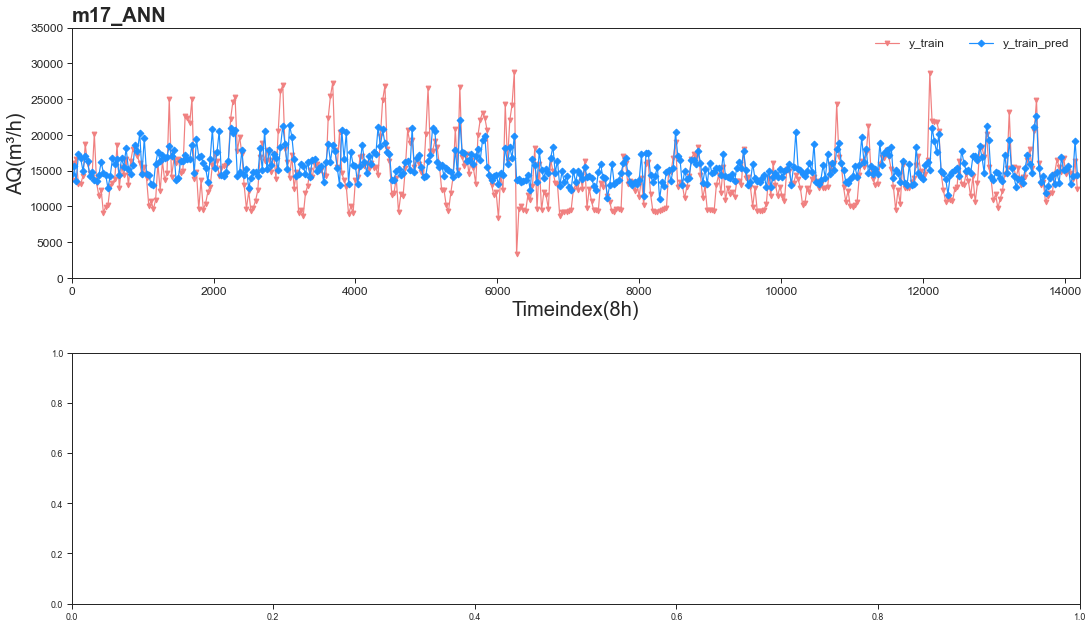

In [170]:
import seaborn as sns
sns.set(context='paper', style='ticks')

fig,axes=plt.subplots(2,1,figsize=(20,10))
ax1=axes[0]
ax2=axes[1]
fig.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)


x=train_index[::32]
y1=y_train['AQ'][::32]
y2=y_train_pred['AQ'][::32]
lns1=ax1.plot(x,y1,label='y_train',marker='v',markevery=1, color='lightcoral')
lns2=ax1.plot(x,y2,label='y_train_pred',marker='D',markevery=1, color='dodgerblue')
ax1.tick_params(labelsize=12)
ax1.set_xlim(0,14208,2000)
ax1.set_ylim(0,35000, 5000)
ax1.set_xlabel('Timeindex(8h)',size=20)
ax1.set_ylabel('AQ(m³/h)',size=20)
ax1.set_title('m17_ANN',size=20,fontweight='bold',loc='left')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=1,fontsize=12,ncol=2,frameon=False)

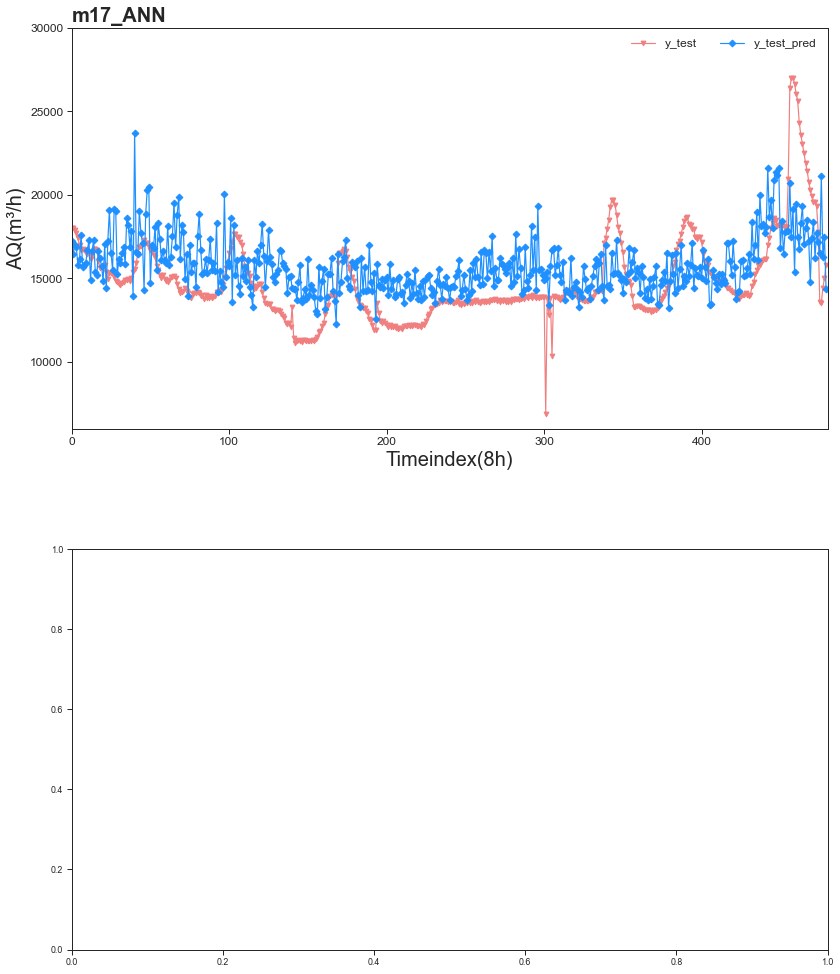

In [171]:
import seaborn as sns
sns.set(context='paper', style='ticks')

fig,axes=plt.subplots(2,1,figsize=(15,16))
ax1=axes[0]
ax2=axes[1]
fig.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)


x=test_index
y1=y_test['AQ']
y2=y_test_pred['AQ']
lns1=ax1.plot(x,y1,label='y_test',marker='v',markevery=1, color='lightcoral')
lns2=ax1.plot(x,y2,label='y_test_pred',marker='D',markevery=1, color='dodgerblue')
ax1.tick_params(labelsize=12)
ax1.set_xlim(0,480,1)
ax1.set_ylim(6000,30000, 5000)
ax1.set_xlabel('Timeindex(8h)',size=20)
ax1.set_ylabel('AQ(m³/h)',size=20)
ax1.set_title('m17_ANN',size=20,fontweight='bold',loc='left')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=1,fontsize=12,ncol=2,frameon=False)

In [172]:
frame=pd.DataFrame()
frame['ytrain']=y_train_pred
frame['ytest']=y_test_pred


In [174]:
frame.to_excel('../goaldata/m5_ANN.xlsx')